In [1]:
from os.path import expanduser
import json
import datetime as dt
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
from functions.plotting.mpl import plot_empty
from functions.auth.connections import postgres_connection

connection_uri = postgres_connection('sf_rent_petitions')

In [2]:
save=False

# Duplicate Entries

In [3]:
# Explore duplicates
query = """
SELECT date, address, neighborhood_name, num_petition_id
FROM petitions
ORDER BY CAST(date AS DATE);
"""
petition_duplicates_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_duplicates_df.date = petition_duplicates_df.date.apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y"))
petition_duplicates_df = petition_duplicates_df.set_index('date')

In [4]:
max(petition_duplicates_df['num_petition_id'])

78

In [5]:
petition_duplicates_df[petition_duplicates_df['num_petition_id'] == 78]

,address,neighborhood_name,num_petition_id
date,,,
2015-04-30,600 Block Of Commercial Street,Chinatown,78


# Tenant vs Landlord

In [6]:
# Explore duplicates
query = """
SELECT filing_party, COUNT(filing_party)
FROM petitions
WHERE filing_party IS NOT NULL
GROUP BY filing_party;
"""
petition_filing_party_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_filing_party_df

,filing_party,count
0,landlord,12562
1,tenant,28184


# Volume over Time for Day, Week, Month, Year

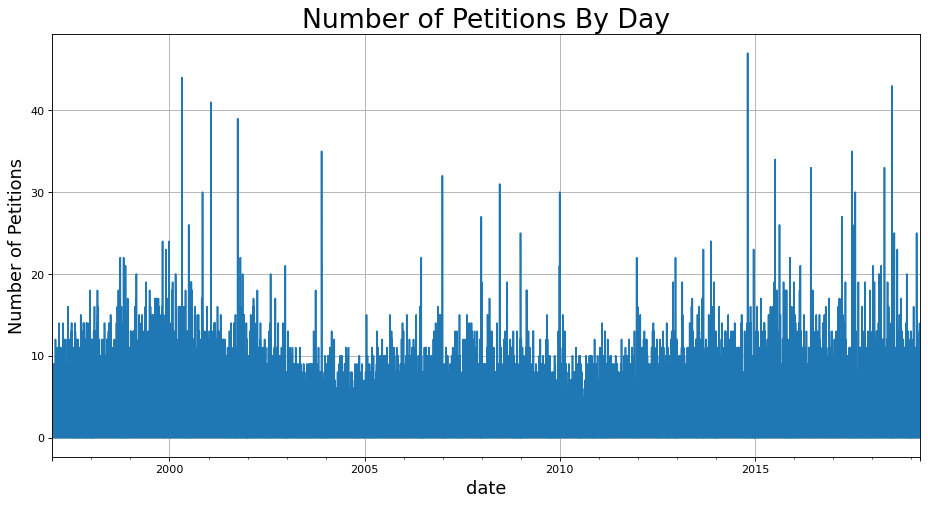

In [7]:
# Group by Day
query = """
SELECT date, COUNT(date)
FROM petitions
GROUP BY date
ORDER BY CAST(date AS DATE);
"""
petition_day_count_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_day_count_df.date = petition_day_count_df.date.apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y"))
petition_day_count_df = petition_day_count_df.set_index('date').resample('D').sum().fillna(0)


# Plot
fig, ax = plot_empty(xlabel='Date', ylabel='Number of Petitions', title='Number of Petitions By Day',
                     figsize= (14, 7))
petition_day_count_df['count'].plot(kind="line", color='#1f77b4', legend = None)
ax.grid(True)

if save:
    plt.savefig("figures/sampling-rate/petitions-by-day.png", transparent=True, bbox_inches="tight")
plt.show()
plt.close()

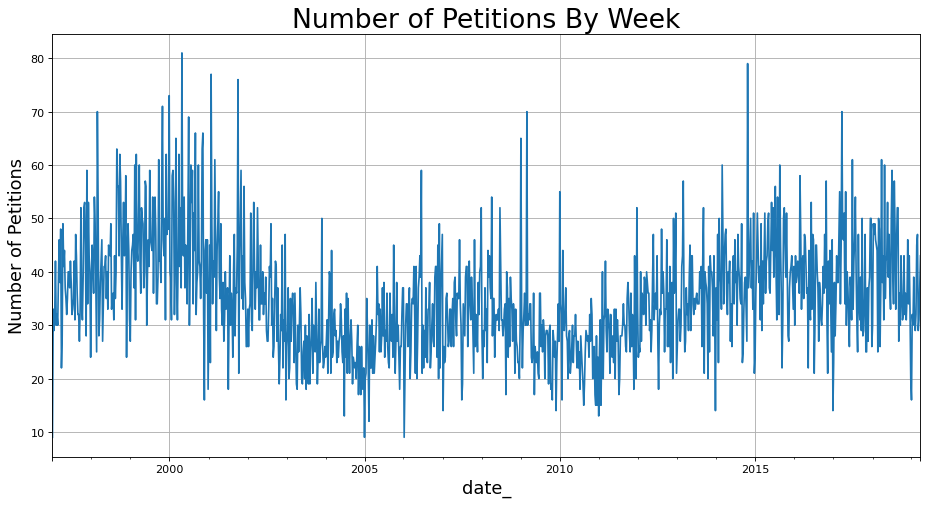

In [8]:
# Group by Week
query = """
SELECT CAST(DATE_TRUNC('WEEK', date::date) AS DATE) +INTERVAL '6' DAY as date_, COUNT(DATE_TRUNC('WEEK', date::date))
FROM petitions
GROUP BY date_
ORDER BY date_;
"""
petition_week_count_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_week_count_df = petition_week_count_df.set_index('date_')


# Plot
fig, ax = plot_empty(xlabel='Date', ylabel='Number of Petitions', title='Number of Petitions By Week',
                     figsize= (14, 7))
petition_week_count_df['count'].plot(kind="line", color='#1f77b4', legend = None)
ax.grid(True)

if save:
    plt.savefig("figures/sampling-rate/petitions-by-week.png", transparent=True, bbox_inches="tight")
plt.show()
plt.close()

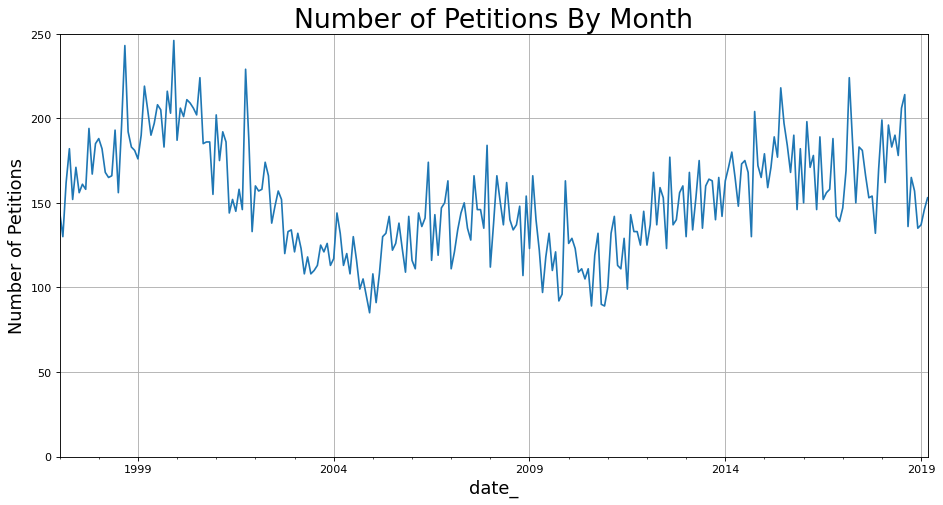

In [9]:
# Group by Month
query = """
SELECT CAST(DATE_TRUNC('MONTH', date::date) AS DATE) +INTERVAL '1' MONTH -INTERVAL '1' DAY AS date_,
    COUNT(DATE_TRUNC('MONTH', date::date))
FROM petitions
GROUP BY date_
ORDER BY date_;
"""
petition_month_count_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_month_count_df = petition_month_count_df.set_index('date_')


# Plot
fig, ax = plot_empty(xlabel='Date', ylabel='Number of Petitions', title='Number of Petitions By Month',
                     figsize= (14, 7))
petition_month_count_df['count'].plot(kind="line", color='#1f77b4', legend = None)
ax.set_ylim(0, 250)
ax.grid(True)

if save:
    plt.savefig("figures/sampling-rate/petitions-by-month.png", transparent=True, bbox_inches="tight")
plt.show()
plt.close()

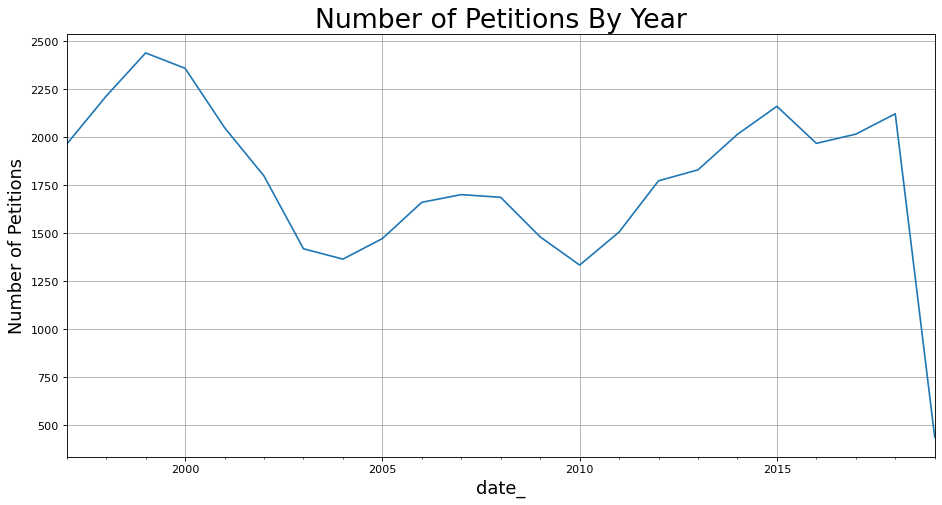

In [10]:
# Group by Year
query = """
SELECT CAST(DATE_TRUNC('YEAR', date::date) AS DATE) +INTERVAL '1' YEAR -INTERVAL '1' DAY AS date_,
    COUNT(DATE_TRUNC('YEAR', date::date))
FROM petitions
GROUP BY date_
ORDER BY date_;
"""
petition_year_count_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_year_count_df = petition_year_count_df.set_index('date_')

# Plot
fig, ax = plot_empty(xlabel='Date', ylabel='Number of Petitions', title='Number of Petitions By Year',
                     figsize= (14, 7))
petition_year_count_df['count'].plot(kind="line", color='#1f77b4', legend = None)
ax.grid(True)

if save:
    plt.savefig("figures/sampling-rate/petitions-by-year.png", transparent=True, bbox_inches="tight")
plt.show()
plt.close()

# Distribution of Counts for Day, Week, Month

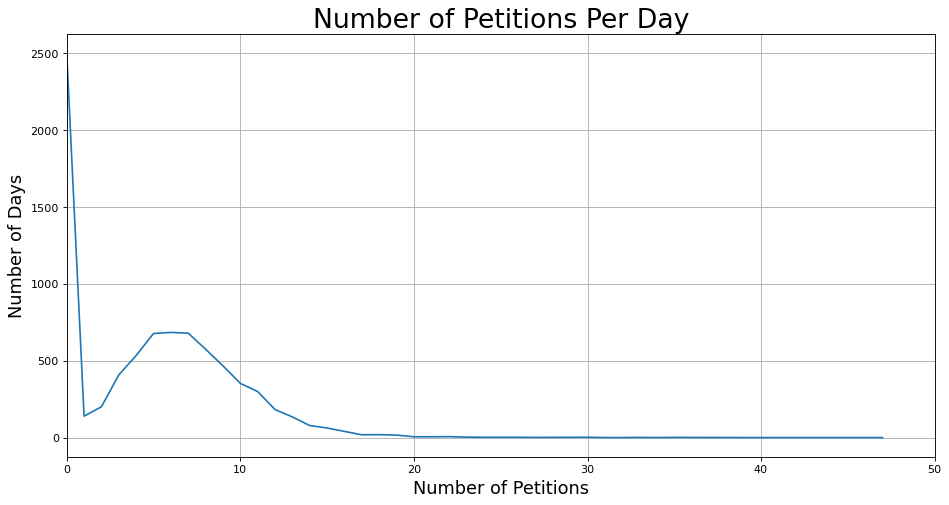

In [11]:
# Group by Day
petition_day_counts_df = pd.DataFrame(petition_day_count_df['count'].value_counts().sort_index()) # includes zero


# Plot counts
fig, ax = plot_empty(xlabel='Number of Petitions', ylabel='Number of Days', title='Number of Petitions Per Day')
petition_day_counts_df['count'].plot(kind="line", color='#1f77b4', figsize = (14,7), legend = None)
ax.set_xlim(0, 50)
ax.grid(True)
if save:
    plt.savefig("figures/sampling-rate/petitions-per-day.png", transparent=True, bbox_inches="tight")

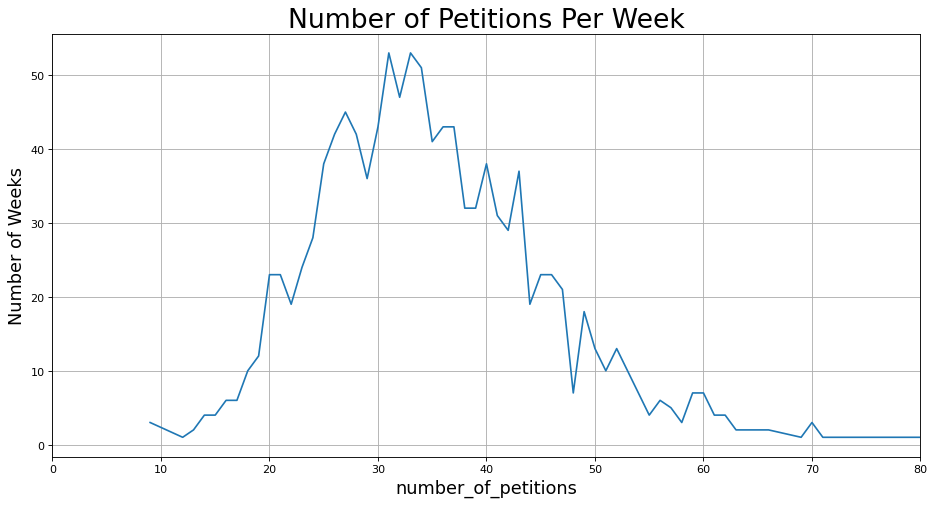

In [12]:
# Group by Week
query = """
SELECT count_table.count AS number_of_petitions, COUNT(count_table.count) AS number_of_weeks
FROM (SELECT COUNT(DATE_TRUNC('WEEK', date::date)) FROM petitions GROUP BY DATE_TRUNC('WEEK', date::date)) as count_table
GROUP BY count_table.count
ORDER BY count_table.count;
"""
petition_week_counts_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_week_counts_df = petition_week_counts_df.set_index('number_of_petitions')

# Plot counts
fig, ax = plot_empty(xlabel='Number of Petitions', ylabel='Number of Weeks', title='Number of Petitions Per Week')
petition_week_counts_df['number_of_weeks'].plot(kind="line", color='#1f77b4', figsize = (14,7), legend = None)
ax.set_xlim(0, 80)
ax.grid(True)
if save:
    plt.savefig("figures/sampling-rate/petitions-per-week.png", transparent=True, bbox_inches="tight")

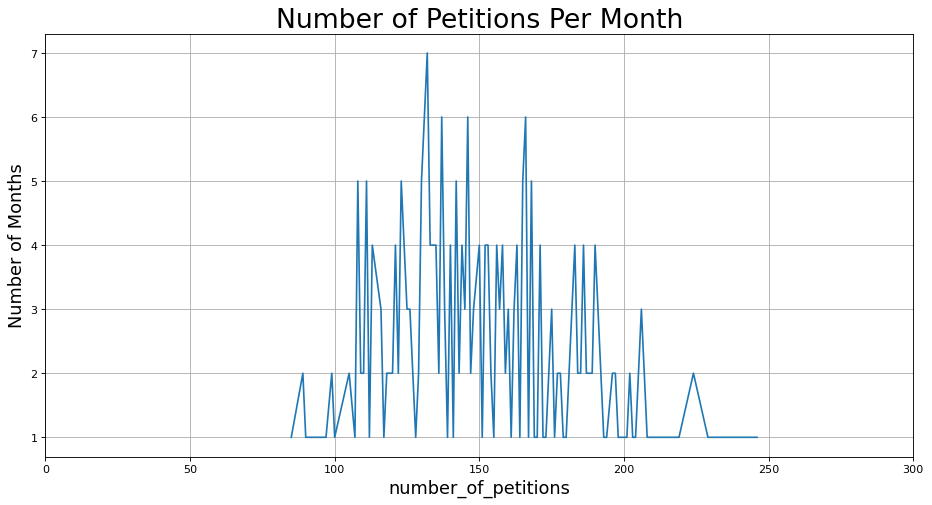

In [13]:
# Group by Month
query = """
SELECT count_table.count AS number_of_petitions, COUNT(count_table.count) AS number_of_months
FROM (SELECT COUNT(DATE_TRUNC('MONTH', date::date)) FROM petitions GROUP BY DATE_TRUNC('MONTH', date::date)) as count_table
GROUP BY count_table.count
ORDER BY count_table.count;
"""
petition_month_counts_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
petition_month_counts_df = petition_month_counts_df.set_index('number_of_petitions')

# Plot counts
fig, ax = plot_empty(xlabel='Number of Petitions', ylabel='Number of Months', title='Number of Petitions Per Month')
petition_month_counts_df['number_of_months'].plot(kind="line", color='#1f77b4', figsize = (14,7), legend = None)
ax.set_xlim(0, 300)
ax.grid(True)

if save:
    plt.savefig("figures/sampling-rate/petitions-per-month.png", transparent=True, bbox_inches="tight")

# Unemployment

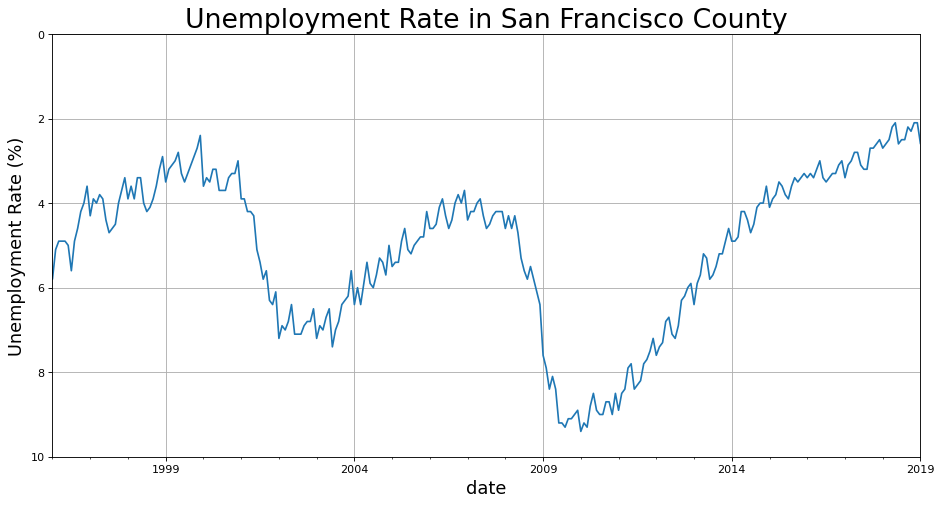

In [14]:
# Unemployment
query = """
SELECT date, unemployment_rate
FROM unemployment
ORDER BY CAST(date AS DATE);
"""
unemployment_df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
unemployment_df.date = unemployment_df.date.apply(lambda x : dt.datetime.strptime(x, "%Y-%m-%d"))
unemployment_df = unemployment_df.set_index('date')

# Plot counts
fig, ax = plot_empty(xlabel='Date', ylabel='Unemployment Rate (%)', title='Unemployment Rate in San Francisco County',
                     figsize=(14, 7))
unemployment_df['unemployment_rate'].plot(kind="line", color='#1f77b4', legend = None)
ax.set_xlim(dt.datetime(1996, 1, 1), dt.datetime(2019, 1, 1))
plt.ylim(10, 0)
ax.grid(True)
if save:
    plt.savefig("figures/sampling-rate/unemployment-by-month.png", transparent=True, bbox_inches="tight")
plt.show()